# load libraries and data directory

In [1]:
suppressMessages(library(oligo)) 
suppressMessages(library(RankProd)) 
suppressMessages(library(limma))
##suppressMessages(library(biomaRt))

library(gplots)
library(plotrix)
library(RColorBrewer)
library(methods)
library(edgeR)
library(ggbiplot)
library(genefilter)

suppressMessages(library(gtools)) 
suppressMessages(library(Hmisc))
suppressMessages(library(minet))
suppressMessages(library(reshape2))
suppressMessages(library(plyr))
suppressMessages(library(outliers))
suppressMessages(library(magrittr))
suppressMessages(library(dplyr))
suppressMessages(library(tidyr))
suppressMessages(library(purrr))
suppressMessages(library(stringr))

library(tibble)
library(readr)

options(stringsAsFactors = FALSE)


Attaching package: ‘gplots’

The following object is masked from ‘package:IRanges’:

    space

The following object is masked from ‘package:stats’:

    lowess


Attaching package: ‘plotrix’

The following object is masked from ‘package:gplots’:

    plotCI

Warning message:
: package ‘RColorBrewer’ was built under R version 3.3.0Loading required package: ggplot2
Loading required package: plyr

Attaching package: ‘plyr’

The following object is masked from ‘package:oligo’:

    summarize

The following object is masked from ‘package:XVector’:

    compact

The following object is masked from ‘package:IRanges’:

    desc

The following object is masked from ‘package:S4Vectors’:

    rename

Loading required package: scales

Attaching package: ‘scales’

The following object is masked from ‘package:plotrix’:

    rescale

Loading required package: grid

Attaching package: ‘genefilter’

The following object is masked from ‘package:base’:

    anyNA

Warning message:
: package ‘lattice’ w

In [2]:
mRNA_data_dir = '/home/guillaume/data/GSK_enfisema/arrays_mRNA/'
mRNA_u219_annotation_dir = '/home/guillaume/data/GSK_enfisema/'
pheno_csv = '/home/guillaume/data/GSK_enfisema/pheno_groups.csv'
working_dir = '/home/guillaume/Documents/GSK_enfisema/'

# read U219 array cell files and RMA normalize

## create phenotypic data_frame

In [3]:
groups = read.csv(pheno_csv,header = TRUE)

fi = list.files(mRNA_data_dir)[grepl('.CEL',list.files(mRNA_data_dir))]

pheno = data_frame(sample = fi) %>% rowwise %>% 
  mutate(patient = strsplit(sample,split='_')[[1]][1],      
         pat = gsub('RF-','',patient),
         pat = gsub('RF','',pat),
         pat = gsub('-1','',pat),
         pat = gsub('-2','',pat),
         pat = gsub('-3','',pat)) %>% ungroup %>% select(-patient)

#pheno$pat[pheno$pat %in% groups$pat]
#pheno$pat[!pheno$pat %in% groups$pat]
#groups$pat[!groups$pat %in% pheno$pat]

pheno %<>% left_join(groups, by='pat') 
write_csv(pheno, str_c(working_dir,'pheno.csv'))

In [4]:
pheno %>% dim

[1] 94 18

## read CEL files

In [5]:
#U219 Affymetrix array
ph <- new("AnnotatedDataFrame", data=pheno)
affy = read.celfiles(str_c(mRNA_data_dir,ph$sample), 
                             phenoData=ph, sampleNames=ph$pat, verbose=F)
affy_rma = rma(affy)

Reading in : /home/guillaume/data/GSK_enfisema/arrays_mRNA/101_G03.CEL
Reading in : /home/guillaume/data/GSK_enfisema/arrays_mRNA/102_G04.CEL
Reading in : /home/guillaume/data/GSK_enfisema/arrays_mRNA/103_G05.CEL
Reading in : /home/guillaume/data/GSK_enfisema/arrays_mRNA/104_G06.CEL
Reading in : /home/guillaume/data/GSK_enfisema/arrays_mRNA/106_T-32_(106)_G08.CEL
Reading in : /home/guillaume/data/GSK_enfisema/arrays_mRNA/107_G09.CEL
Reading in : /home/guillaume/data/GSK_enfisema/arrays_mRNA/108_T-42_(108)_G10.CEL
Reading in : /home/guillaume/data/GSK_enfisema/arrays_mRNA/109_T-31_(109)_G11.CEL
Reading in : /home/guillaume/data/GSK_enfisema/arrays_mRNA/10_A09.CEL
Reading in : /home/guillaume/data/GSK_enfisema/arrays_mRNA/110_T-30_(110)_G12.CEL
Reading in : /home/guillaume/data/GSK_enfisema/arrays_mRNA/111_H01.CEL
Reading in : /home/guillaume/data/GSK_enfisema/arrays_mRNA/112_H02.CEL
Reading in : /home/guillaume/data/GSK_enfisema/arrays_mRNA/113_H03.CEL
Reading in : /home/guillaume/data/

Warning message:
In read.celfiles(str_c(mRNA_data_dir, ph$sample), phenoData = ph, : 'channel' automatically added to varMetadata in phenoData.

Background correcting
Normalizing
Calculating Expression


In [6]:
affy_rma %>% head

ExpressionSet (storageMode: lockedEnvironment)
assayData: 1 features, 94 samples 
  element names: exprs 
protocolData
  rowNames: 1 2 ... 94 (94 total)
  varLabels: exprs dates
  varMetadata: labelDescription channel
phenoData
  rowNames: 1 2 ... 3 (94 total)
  varLabels: sample pat ... batch (18 total)
  varMetadata: labelDescription channel
featureData: none
experimentData: use 'experimentData(object)'
Annotation: pd.hg.u219 

In [7]:
data_rma = as.data.frame(exprs(affy_rma)[,])
pheno = pData(phenoData(affy_rma))
pheno %<>% mutate(DLCO = ifelse(is.na(DLCO),00,DLCO), ID = str_c(pat,DLCO,sep='_'))
colnames(data_rma) = pheno$ID
data_rma[1:5,1:5]

,101_41,102_59,103_42,104_48,106_50
11715100_at,4.161239,3.760154,4.413014,4.461558,4.109672
11715101_s_at,5.063633,4.853304,4.980275,5.116125,5.075902
11715102_x_at,3.660032,3.905466,3.782236,3.969975,3.682786
11715103_x_at,4.036723,4.062408,3.963214,4.181952,4.226437
11715104_s_at,4.150746,3.876433,3.959996,4.268308,4.005087


# mapping probe id to gene id with affymetrix annotation csv

## load annotation file

In [8]:
probe_entrez = read_csv(
str_c(mRNA_u219_annotation_dir,'HG-U219.na36.annot_affymetrixwebsite_march2016.csv'),
                       skip=25)
probe_entrez = probe_entrez[,c(1,15,19)] %>% as_data_frame
colnames(probe_entrez) = c('probe_set_id','gene_symbol','entrez')
probe_entrez = data_frame(probe_set_id = row.names(data_rma)) %>% left_join(probe_entrez)
write_csv(probe_entrez, str_c(working_dir,'probe_entrez.csv'))

sum(row.names(data_rma) == probe_entrez$probe_set_id)
sum(!row.names(data_rma) == probe_entrez$probe_set_id)
probe_entrez %>% head

Joining, by = "probe_set_id"


[1] 49386

[1] 0

,probe_set_id,gene_symbol,entrez
1,11715100_at,HIST1H3G,8355
2,11715101_s_at,HIST1H3G,8355
3,11715102_x_at,HIST1H3G,8355
4,11715103_x_at,TNFAIP8L1,126282
5,11715104_s_at,OTOP2,92736
6,11715105_at,C17orf78,284099


## filter probes: 
- remove probes without gene symbol or without entrez id
- keep only one probe per gene symbol/entrez id

In [9]:
probe_entrez %>% dim
probe_entrez_f = probe_entrez %<>% rowwise %>% mutate(entrez = as.character(entrez),
                entrez = str_replace_all(entrez,' ',''),
                gene_symbol = str_replace_all(gene_symbol,' ',''),
                entrez = word(entrez,1,sep = '///'),
                gene_symbol = word(gene_symbol,1,sep = '///')) %>%
ungroup %>%
filter(entrez != '---', gene_symbol != '---', !is.na(entrez),
       !is.na(gene_symbol),
      entrez != '', gene_symbol != '')  %>% distinct(entrez, .keep_all = TRUE) %>% 
distinct(gene_symbol, .keep_all = TRUE)

write_csv(probe_entrez_f, str_c(working_dir,'probe_entrez_filtered.csv'))
probe_entrez_f %>% dim

[1] 49386     3

[1] 19289     3

In [10]:
data_rma_f = data_rma[row.names(data_rma) %in% probe_entrez_f$probe_set_id,]
probe_entrez_f = data_frame(probe_set_id = row.names(data_rma_f)) %>% left_join(probe_entrez_f)

sum(row.names(data_rma_f) == probe_entrez_f$probe_set_id)
sum(!row.names(data_rma_f) == probe_entrez_f$probe_set_id)
row.names(data_rma_f) = probe_entrez_f$gene_symbol
data_rma_f[1:5,1:5]

Joining, by = "probe_set_id"


[1] 19289

[1] 0

,101_41,102_59,103_42,104_48,106_50
HIST1H3G,4.161239,3.760154,4.413014,4.461558,4.109672
TNFAIP8L1,4.036723,4.062408,3.963214,4.181952,4.226437
OTOP2,4.150746,3.876433,3.959996,4.268308,4.005087
C17orf78,3.923032,3.918216,4.194412,4.028379,4.023533
CTAGE15,4.268796,4.570817,4.292928,4.827885,4.984516


## filter patients to match miRNA data

In [13]:
# reorder data_rma_f to match data_rma_f
micro_pheno = read.csv(str_c(working_dir,'microRNA_RankProd_pheno_groups.csv')) %>%
mutate(ID = str_c(pat,DLCO,sep='_')) %>% filter(ID %in% colnames(data_rma_f))
m_data = data_rma_f[,micro_pheno$ID] 

m_data %>% head

,106_50,107_46,108_27,109_25,110_26,113_39,102_59,104_48,10_81,111_29,⋯,50_52.24,55_53.13,59_87.41,5_86.72,62_85.27,66_83.14,67_86.53,79_47.69,81_59.33,85D_35.38
HIST1H3G,4.109672,4.249955,4.032482,4.111225,3.979057,4.157723,3.760154,4.461558,4.006363,4.065833,⋯,4.128118,4.108032,4.245987,4.198894,3.989621,3.910868,4.167421,4.231141,3.769384,3.482143
TNFAIP8L1,4.226437,4.520248,4.890690,4.333590,4.152410,3.997699,4.062408,4.181952,4.584795,5.359160,⋯,6.861430,4.516654,4.775726,4.330306,4.668954,4.323778,4.315775,4.603000,4.324413,4.376741
OTOP2,4.005087,3.781513,3.819071,4.026712,3.854861,3.847746,3.876433,4.268308,4.174503,3.852225,⋯,3.957092,3.973782,3.630989,3.743268,3.654923,4.000429,3.814970,3.839591,3.780624,3.717239
C17orf78,4.023533,3.963351,3.738254,4.145796,3.934114,4.189675,3.918216,4.028379,4.020335,3.869492,⋯,4.052610,4.043063,3.800705,4.162466,3.751413,3.795327,4.147778,4.342053,3.963774,3.900385
CTAGE15,4.984516,4.372485,4.176120,4.737526,4.304329,4.701305,4.570817,4.827885,4.438678,4.262611,⋯,4.593094,4.616101,4.066373,4.618149,4.910896,4.162702,4.552292,4.939274,4.534706,4.667289
F8A1,3.889934,3.917050,3.575445,3.705778,3.735647,3.656350,4.105100,3.435304,3.984056,3.886181,⋯,4.047988,4.083135,3.881718,3.984845,3.829018,4.353590,3.929950,3.520745,3.955731,3.769737


## filter probes with low expression

In [32]:
m_data %>% dim
m_data_f_low = varFilter(as.matrix(m_data)) # %>% varFilter
m_data_f_low %>% dim

[1] 19289    34

[1] 9644   34

# PCA

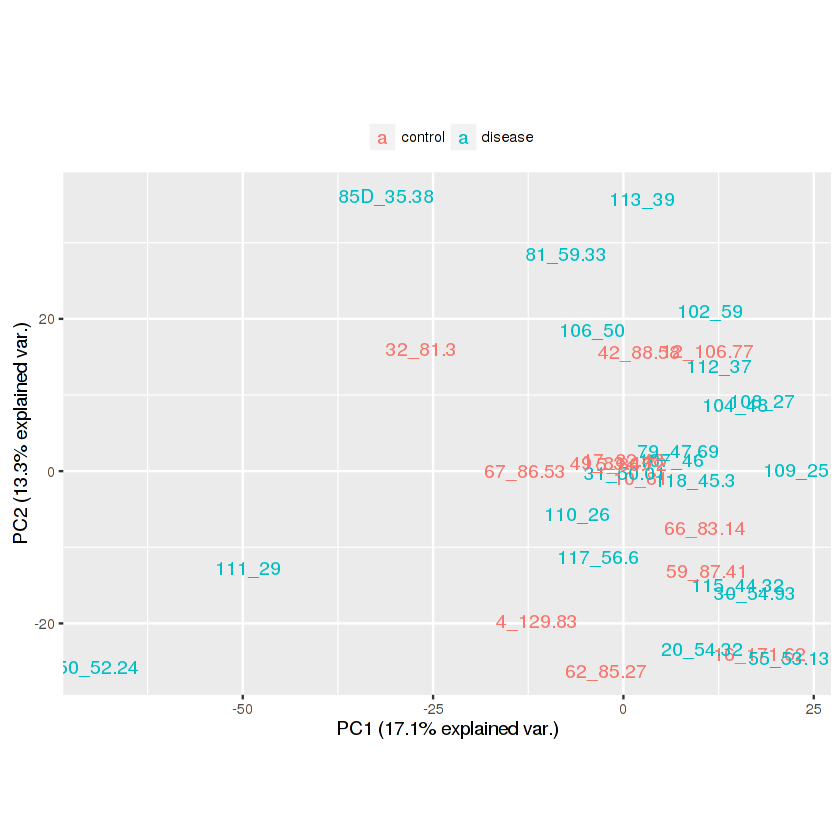

In [33]:
ir.pca <- prcomp(m_data_f_low %>% t)
#plot(ir.pca, type = "l")
g <- ggbiplot(ir.pca, obs.scale = 1, var.scale = 1, choices = 1:2, labels.size = 4,
              ellipse = F, circle = F, groups = micro_pheno$dlco_group,
              var.axes = F, labels = micro_pheno$ID)
              g <- g + scale_color_discrete(name = '')
g <- g + theme(legend.direction = 'horizontal',
               legend.position = 'top')
print(g)

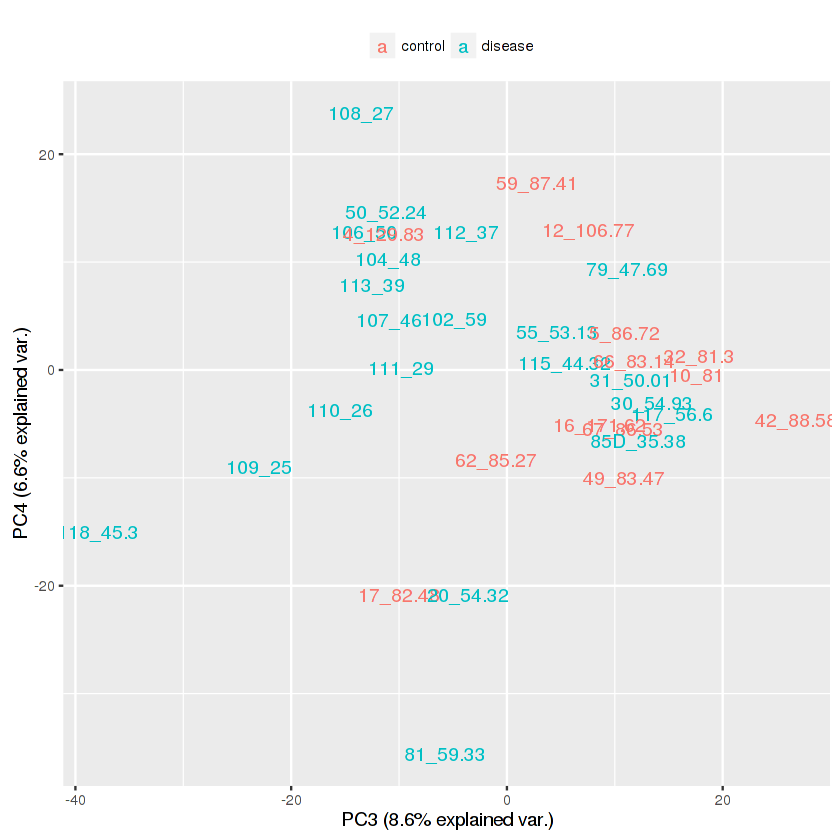

In [34]:
ir.pca <- prcomp(m_data_f_low %>% t)
#plot(ir.pca, type = "l")
g <- ggbiplot(ir.pca, obs.scale = 1, var.scale = 1, choices = 3:4, labels.size = 4,
              ellipse = F, circle = F, groups = micro_pheno$dlco_group,
              var.axes = F, labels = micro_pheno$ID)
              g <- g + scale_color_discrete(name = '')
g <- g + theme(legend.direction = 'horizontal',
               legend.position = 'top')
print(g)

# RankProd

In [35]:
toRP = m_data_f_low
toRP_classes = micro_pheno$dlco_group
RP.out <- RP(toRP ,toRP_classes, num.perm = 100, gene.names=row.names(toRP),
                logged = TRUE, na.rm = FALSE, plot = F, rand = 123) 

Rank Product analysis for two-class case 
 
 
Starting 100 permutations... 
Computing pfp .. 
Outputing the results .. 


In [58]:
  b <- topGene(RP.out, cutoff = 0.05, logged = TRUE, method="pfp",
               gene.names=row.names(toRP), logbase = 2)$Table1 %>% as.data.frame %>% rownames_to_column(var = 'gene_symbol')
  a <- topGene(RP.out, cutoff = 0.05, logged = TRUE, method="pfp",
               gene.names=row.names(toRP), logbase = 2)$Table2 %>% as.data.frame %>% rownames_to_column(var = 'gene_symbol')
b %>% dim
a %>% dim
top_rankprod = b %>% bind_rows(a) %>% mutate(
    FC = ifelse(`FC:(class1/class2)` < 1, 1/`FC:(class1/class2)`, `FC:(class1/class2)`)) %>%
filter(FC > 1.5) %>% arrange(desc(FC))

write_csv(top_rankprod,'~/Downloads/tmp/top_rankprod_full_genes.csv')


# list of top microRNAs for enrichment with mirpath: http://snf-515788.vm.okeanos.grnet.gr/index.php?r=mirpath/index
write_csv(top_rankprod %>% dplyr::select(gene_symbol),'~/Downloads/tmp/top_rankprod_genes.csv', col_names = F)

top_rankprod %>% mutate(nn = nrow(.)) %>% head

Table1: Genes called significant under class1 < class2 

Table2: Genes called significant under class1 > class2 

Table1: Genes called significant under class1 < class2 

Table2: Genes called significant under class1 > class2 



[1] 241   6

[1] 198   6

,gene_symbol,gene.index,RP/Rsum,FC:(class1/class2),pfp,P.value,FC,nn
1,HLA-C,51,203.4106,0.3083,0,0,3.243594,105
2,DEFA1,2318,202.3373,0.3669,0,0,2.725538,105
3,ITLN1,2921,487.3658,0.4160,0,0,2.403846,105
4,PPBP,8180,292.6338,0.4355,0,0,2.296211,105
5,IGHM,9542,388.6672,0.4591,0,0,2.178175,105
6,RFX2,7665,343.2355,2.1530,0,0,2.153000,105


# heatmap

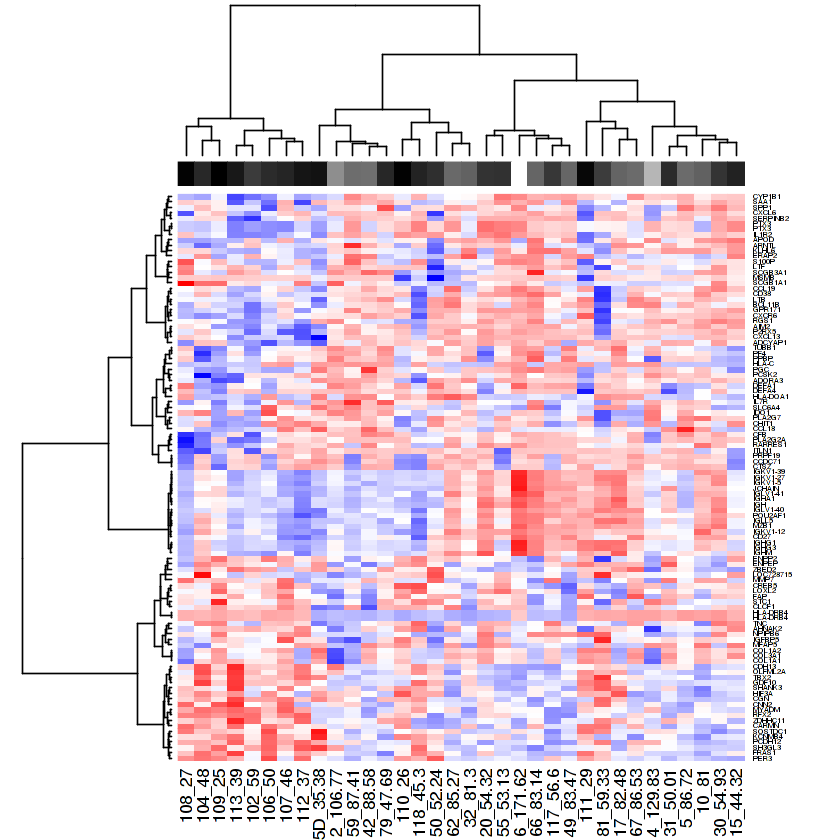

In [66]:
clust_methods = c("ward.D","ward.D2","single","complete","average","mcquitty","median","centroid")
dist.pear <- function(x) as.dist(1-cor(t(x)))
hclust.ave <- function(x) hclust(x, method=clust_methods[1])
hmcols<-colorRampPalette(c("red","white","blue"))(256)
hmcol<-brewer.pal(11,"RdBu")

var2 <- micro_pheno$dlco_group
var2 <- replace(var2, which(var2 == 'disease'), "magenta")
var2 <- replace(var2, which(var2 == 'control'), "deepskyblue")
    
heatmap(m_data_f_low[top_rankprod$gene_symbol,] %>% as.matrix, 
        #ColSideColors= var2, 
        ColSideColors= color.scale(micro_pheno$DLCO),
        col=hmcols, 
        distfun=dist.pear, hclustfun=hclust.ave,
        cexRow = 0.5,cexCol = 1.25)